<a href="https://colab.research.google.com/github/KenObata/TISMIR_notebooks/blob/main/Models_from_music4all_on_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week15: This notebook uses Pre-Trained RoBERTa

Situation: English only (=multi-class).
Split: StratifiedKfold.
Reference: https://github.com/jasonwei20/eda_nlp


### set up

In [1]:
!pip3 install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.2 MB/s 


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

def get_balanced_accuracy(model_name ,model, McNemar, is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning):
  test_y = test.map(map_func_only_y)
  y_category=np.zeros((TEST_SIZE, ))
  counter=0
  for label_tensor in test_y.take(len(test_y)):
    y_test = np.argmax(label_tensor, axis=1)
    for label in y_test:
      y_category[counter]=label
      counter+=1

  X_test, y_test = test.map(map_func_only_X), y_category
  y_predict_test = np.asarray(model.predict(X_test))
  y_predict_test = np.argmax(y_predict_test, axis=1)
  print(classification_report(y_test, y_predict_test) )
  print(balanced_accuracy_score(y_test, y_predict_test))

  McNemar[(is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning)] = []
  for ground_truh, pred in zip(y_test, y_predict_test):
        if ground_truh==pred:
          McNemar[(is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning)].append(True)
        else:
          McNemar[(is_fine_tuning, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning)].append(False)
  with open(DIR+ "Music4AllModel_pred_on_kaggle_log.txt", "a") as f:
    print("======================================", file=f)
    print("model name:", model_name, "is_fine_tuning?:", is_fine_tuning, "drop_out_rate: ", drop_out_rate, "learning_rate_transfer_learning: ", learning_rate_transfer_learning,
          "learning_rate_fine_tuning: ", learning_rate_fine_tuning, file=f)
    print(classification_report(y_test, y_predict_test) , file=f)
    print(balanced_accuracy_score(y_test, y_predict_test), file=f)

  return balanced_accuracy_score(y_test, y_predict_test), McNemar, y_predict_test

In [4]:
DIR = '/content/drive/MyDrive/music4all/'

### Get only overlapping genre

In [5]:
import pandas as pd

DIR = '/content/drive/MyDrive/music4all/'
df_genre_by_lang = pd.read_csv(DIR + 'kaggle/df_kaggle.csv')
df_genre_by_lang = df_genre_by_lang.drop(columns = ['Unnamed: 0'])
df_genre_by_lang

ParserError: ignored

In [ ]:
Counter(df_genre_by_lang['Genre'])

treat 'Hip-Hop' = Rap

In [ ]:
overlap_genres = ['Hip-Hop','Pop', 'Rock', 'Electronic', 'Folk']
df_genre_by_lang_overlap = df_genre_by_lang[df_genre_by_lang['Genre'].isin(overlap_genres)]
df_genre_by_lang_overlap

In [ ]:
Counter(df_genre_by_lang_overlap['Genre'])

Save as csv

In [ ]:
DIR

In [ ]:
df_genre_by_lang_overlap.to_csv(DIR + 'kaggle/df_kaggle_overlap.csv')

In [ ]:
df_genre_by_lang_overlap = df_genre_by_lang_overlap.reset_index(drop=True)

### Load kaggle overlapping data

In [5]:
import pandas as pd
filename = DIR + 'kaggle/df_kaggle_overlap.csv'

df_genre_by_lang_overlap = pd.read_csv(filename)
df_genre_by_lang_overlap = df_genre_by_lang_overlap.drop(columns = ['Unnamed: 0'])
df_genre_by_lang_overlap

,Genre,Lyrics
0,Hip-Hop,Most folks spend their days daydreaming of fin...
1,Pop,You ask me why I change the color of my hair\n...
2,Hip-Hop,Do you believe in magic in a young girl's hear...
3,Hip-Hop,"Tell Mel Shawn to come in\nWord, yo, one life ..."
4,Pop,"Gee, how I miss\nYour tender kiss,\nAnd the wo..."
...,...,...
210477,Pop,"You wanna, you wanna You want a hot body? You ..."
210478,Electronic,It's complicated It always is That's just the ...
210479,Pop,"Bad Boys Blue ""I Totally Miss You"" I did you w..."
210480,Pop,Forgive me for the things That I never said to...


### Data Preparation(Kfold split)

Create dataframe for Gensim

In [6]:
def load_data(df_col, y):
    texts, labels = [], []
    
    for line in df_col:
        # texts are already tokenized, just split on space
        # in a real use-case we would put more effort in preprocessing
        texts.append(line.split(' '))
    return pd.DataFrame({'texts': texts, 'labels': y})

In [7]:
data = load_data(df_genre_by_lang_overlap["Lyrics"], df_genre_by_lang_overlap["Genre"])

In [8]:
data

,texts,labels
0,"[Most, folks, spend, their, days, daydreaming,...",Hip-Hop
1,"[You, ask, me, why, I, change, the, color, of,...",Pop
2,"[Do, you, believe, in, magic, in, a, young, gi...",Hip-Hop
3,"[Tell, Mel, Shawn, to, come, in\nWord,, yo,, o...",Hip-Hop
4,"[Gee,, how, I, miss\nYour, tender, kiss,\nAnd,...",Pop
...,...,...
210477,"[You, wanna,, you, wanna, You, want, a, hot, b...",Pop
210478,"[It's, complicated, It, always, is, That's, ju...",Electronic
210479,"[Bad, Boys, Blue, ""I, Totally, Miss, You"", I, ...",Pop
210480,"[Forgive, me, for, the, things, That, I, never...",Pop


In [9]:
data['labels'] = data['labels'].astype('category')
label_mapping = data['labels'].cat.categories
data['labels'] = data['labels'].cat.codes
X = data['texts']
y = data['labels']

In [10]:
type(X)

pandas.core.series.Series

In [11]:
def StratifiedKFold_feature_and_df_glove(df, feature_list, y_name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  y = df[y_name]
  skf.get_n_splits(df[ feature_list ], y)

  splits = []

  for train_index, test_index in skf.split(df[ feature_list ], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[ feature_list ].loc[train_index], df[ feature_list ].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [12]:
def StratifiedKFold_feature_and_df(X, y):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  #y = df[y_name]
  skf.get_n_splits(X, y)#df[ feature_list ]

  splits = []

  for train_index, test_index in skf.split(X, y):#df[ feature_list ]
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [13]:
#feature_list = ["texts"] #this is BOW and TF-IDF
#splits = StratifiedKFold_feature_and_df( data, feature_list, 'labels')
splits = StratifiedKFold_feature_and_df( X,y)

TRAIN: [     1      2      3 ... 210479 210480 210481] TEST: [     0      4     13 ... 210471 210474 210478]
TRAIN: [     0      1      2 ... 210477 210478 210481] TEST: [     3      9     15 ... 210476 210479 210480]
TRAIN: [     0      2      3 ... 210479 210480 210481] TEST: [     1      5     21 ... 210465 210466 210475]
TRAIN: [     0      1      2 ... 210478 210479 210480] TEST: [     6     23     24 ... 210460 210470 210481]
TRAIN: [     0      1      3 ... 210479 210480 210481] TEST: [     2      7      8 ... 210467 210472 210477]


In [14]:
len(splits)

5

In [15]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
print(split0['X_test'].shape)
print(split0['y_test'].shape)

(168385,)
(168385,)
(42097,)
(42097,)


In [16]:
split0['X_train']

1         [You, ask, me, why, I, change, the, color, of,...
2         [Do, you, believe, in, magic, in, a, young, gi...
3         [Tell, Mel, Shawn, to, come, in\nWord,, yo,, o...
5         [[Eminem, Intro, from, "Cleanin, out, my, clos...
6         [Take, off, your, shoes\nSit, on, the, floor\n...
                                ...                        
210476    [[Mr., Cheeks], Basically,, LB, Fam, to, the, ...
210477    [You, wanna,, you, wanna, You, want, a, hot, b...
210479    [Bad, Boys, Blue, "I, Totally, Miss, You", I, ...
210480    [Forgive, me, for, the, things, That, I, never...
210481    [Fourth, of, July, has, come,, it's, custom, t...
Name: texts, Length: 168385, dtype: object

In [17]:
split0['y_train']

1         3
2         2
3         2
5         2
6         3
         ..
210476    2
210477    3
210479    3
210480    3
210481    3
Name: labels, Length: 168385, dtype: int8

In [18]:
counter_origin = Counter(df_genre_by_lang_overlap['Genre'])
counter_origin = sorted(counter_origin.items(), key= lambda k:k[1])
counter_origin

[('Electronic', 2664),
 ('Hip-Hop', 3198),
 ('Folk', 8660),
 ('Pop', 87405),
 ('Rock', 108555)]

In [19]:
counter_code = Counter(split0['y_train'])
counter_code= sorted(counter_code.items(), key= lambda k:k[1])
counter_code

[(0, 2131), (2, 2558), (1, 6928), (3, 69924), (4, 86844)]

In [20]:
code2genre = {
     0: 'Electronic'
    , 1:'Folk'
    , 2: 'Hip-Hop'
    , 3:'Pop'
    , 4: 'Rock'
}
code2genre

{0: 'Electronic', 1: 'Folk', 2: 'Hip-Hop', 3: 'Pop', 4: 'Rock'}

### (Part1) Gensim Implementation

Parameter

sg=1 means to use skip-gram

min_count... is a threashhold that the algorithm requires a word need to appear at least x time ot be considered as part of skip-gram algorithm.

size... is the # of dimensions.

iterations ... ?


In [21]:
GLOVE_ZIP_FILE ="drive/MyDrive/music4all/glove.6B.zip"

!unzip drive/MyDrive/music4all/glove.6B.zip -d /content/

Archive:  drive/MyDrive/music4all/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


### Gensim Word2Vec Class

Ref:https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights
Ref:https://gist.github.com/AbhishekAshokDubey/054af6f92d67d5ef8300fac58f59fcc9


In [22]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec, Phrases, phrases, KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

class GensimWord2VecVectorizer(BaseEstimator, TransformerMixin):
    """
    Word vectors are averaged across to create the document-level vectors/features.
    gensim's own gensim.sklearn_api.W2VTransformer doesn't support out of vocabulary words,
    hence we roll out our own.
    All the parameters are gensim.models.Word2Vec's parameters.
    https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
    """
    
    def __init__(self, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None,
                 sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5,
                 ns_exponent=0.75, cbow_mean=1, hashfxn=hash, iter=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False,
                 callbacks=(), max_final_vocab=None):
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.ns_exponent = ns_exponent
        self.cbow_mean = cbow_mean
        self.hashfxn = hashfxn
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words
        self.compute_loss = compute_loss
        self.callbacks = callbacks
        self.max_final_vocab = max_final_vocab

    def fit(self, X, y=None):
        self.model_ = Word2Vec(
            sentences=X, corpus_file=None,
            size=self.size, alpha=self.alpha, window=self.window, min_count=self.min_count,
            max_vocab_size=self.max_vocab_size, sample=self.sample, seed=self.seed,
            workers=self.workers, min_alpha=self.min_alpha, sg=self.sg, hs=self.hs,
            negative=self.negative, ns_exponent=self.ns_exponent, cbow_mean=self.cbow_mean,
            hashfxn=self.hashfxn, iter=self.iter, null_word=self.null_word,
            trim_rule=self.trim_rule, sorted_vocab=self.sorted_vocab, batch_words=self.batch_words,
            compute_loss=self.compute_loss, callbacks=self.callbacks,
            max_final_vocab=self.max_final_vocab)

        #My code added
        #google_wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        #Ref: https://radimrehurek.com/gensim/scripts/glove2word2vec.html
        

        print("Created glove_wv.")
        print("Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab : ", len(self.model_.wv.vocab))

        #self.model_.build_vocab(X)
        training_examples_count = self.model_.corpus_count
        print("original training_examples_count:", training_examples_count)
        print("Before merge, vocab: ", len(self.model_.wv.vocab))

        if self.size ==100:
          # load the Stanford GloVe model
          glove_input_file = 'glove.6B.100d.txt'
          word2vec_output_file = 'glove.6B.100d.txt.word2vec'
          glove2word2vec(glove_input_file, word2vec_output_file)
          filename = word2vec_output_file
          glove_wv = KeyedVectors.load_word2vec_format(filename, binary=False)
        elif self.size ==200:
          glove_input_file = 'glove.6B.200d.txt'
          word2vec_output_file = 'glove.6B.200d.txt.word2vec'
          glove2word2vec(glove_input_file, word2vec_output_file)
          filename = word2vec_output_file
          glove_wv = KeyedVectors.load_word2vec_format(filename, binary=False)
        elif self.size ==300:
          glove_input_file = 'glove.6B.300d.txt'
          word2vec_output_file = 'glove.6B.300d.txt.word2vec'
          glove2word2vec(glove_input_file, word2vec_output_file)
          filename = word2vec_output_file
          glove_wv = KeyedVectors.load_word2vec_format(filename, binary=False)


        self.model_.build_vocab([list(glove_wv.vocab.keys())], update=True)
        print("Updated build_vocab by Glove.")
        #self.model_.intersect_word2vec_format(glove_file, binary=False, lockf=1.0)#try this
        self.model_.intersect_word2vec_format(filename, binary=False, lockf=1.0)
        print("intersect completed.")
        self.model_.train(X, total_examples=training_examples_count, epochs=self.model_.iter)

        print("After merge, vocab: ", len(self.model_.wv.vocab))
        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words if word in self.model_.wv.vocab]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_.wv[word]

            return np.mean(embedding, axis=0)
        else:
            return np.zeros(self.size)

### Preprocess my lyrics data (Official train and test)

In [24]:
import tensorflow as tf
!pip3 install transformers
SEQ_LEN = 256#512

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 4.0 MB/s 
     |████████████████████████████████| 6.6 MB 53.7 MB/s 
     |████████████████████████████████| 120 kB 59.6 MB/s 


In [32]:
split0['X_test']

0         [Most, folks, spend, their, days, daydreaming,...
4         [Gee,, how, I, miss\nYour, tender, kiss,\nAnd,...
13        [We, love, the, fire\nWe, love, the, danger\nW...
14        [She's, got, a, way, about, her\nI, don't, kno...
20        [Stones, and, flowers, on, the, ground\nWe, ar...
                                ...                        
210468    [Who, I'm, is?, The, phenom,, them, niggas, ca...
210469    [Come, on,, ha,, you, want, it, want, it, Come...
210471    [T, sciln, na, 'gam, le, h-insint, dibhse,, Cr...
210474    [She, doesn't, want, me, around, She's, got, s...
210478    [It's, complicated, It, always, is, That's, ju...
Name: texts, Length: 42097, dtype: object

In [31]:
def prepare_lyrics(X_series):
  for i, token_list in X_series.items():
    if type(token_list) is list:
      X_series.loc[i] = ' '.join(token_list)
  return X_series

In [32]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
SEQ_LEN=256

def get_Xid_Xmask(X_origin):
  Xids_train = np.zeros((X_origin.shape[0], SEQ_LEN))
  Xmask_train = np.zeros((X_origin.shape[0], SEQ_LEN))

  for i, lyric in enumerate(X_origin):
    tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
    Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']
  return Xids_train, Xmask_train

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [33]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask':masks}, labels

In [36]:
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )
#tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')
Xids_train, Xmask_train = get_Xid_Xmask(split0['X_train'])
Xids_test, Xmask_test = get_Xid_Xmask(split0['X_test'])

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

dataset_train = dataset_train.shuffle(42).batch(16)
DS_LEN = len(list(dataset_train))
SPLIT=0.85
train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

In [25]:
counter = Counter(split0['y_train'])
SUM=0
for item in list(counter.values()) :
  SUM+=item
#SUM = sum(counter.values())
SUM

168385

In [26]:
#Tutorial
#weight_for_0 = (1 / neg) * (total / 2.0)
#weight_for_1 = (1 / pos) * (total / 2.0)

counter = Counter(split0['y_train'])
my_weight2 = {}
print(counter)

for genre in counter:
  #print(genre, counter[genre])
  my_weight2[genre] = (1/counter[genre]) * (SUM/10)
my_weight2

Counter({4: 86844, 3: 69924, 1: 6928, 2: 2558, 0: 2131})


{3: 0.2408114524340713,
 2: 6.582681782642689,
 4: 0.193893648381005,
 0: 7.901689347724073,
 1: 2.4304994226327943}

In [39]:
TEST_SIZE = len(split0['X_test'])
TEST_SIZE

42097

In [40]:
print(int(len(split0['y_train'])*0.85), int(len(split0['y_train'])*0.15), len(split0['y_test']))

total = int(len(split0['y_train'])*0.85)+ int(len(split0['y_train'])*0.15)+ len(split0['y_test']) 
print(int(len(split0['y_train'])*0.85)/total, int(len(split0['y_train'])*0.15)/total, len(split0['y_test'])/total)

143127 25257 42097
0.6799996199181874 0.11999657926368651 0.2000038008181261


In [27]:
def map_func_only_X(val_dictionary, labels):
  return {'input_ids': val_dictionary['input_ids'], 'attention_mask':val_dictionary['attention_mask']}

In [28]:
def map_func_only_y(val_dictionary, labels):
  return labels

In [29]:
McNemar = {}
balanced_accuracies_transfer_learning=[]
balanced_accuracies_fine_tuning=[]

### Load RoBERTa from Music4All and predict

In [24]:
drop_out_rate = 0.3
learning_rate_transfer_learning = 1e-3
learning_rate_fine_tuning = 1e-5
McNemar={}
balanced_accuracies_fine_tune =[]

In [44]:
from transformers import TFAutoModel


SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1
roberta = TFAutoModel.from_pretrained('roberta-base')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = roberta(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
X = tf.keras.layers.BatchNormalization()(X)#added
X = tf.keras.layers.Dropout(drop_out_rate)(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

learning_rate_transfer_learning:  0.001 learning_rate_fine_tuning:  1e-05 drop_out_rate: 0.3


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [29]:
model1.load_weights('/content/drive/MyDrive/music4all/checkpoints/RoBERTa_music4all_split4_finetuned')

In [46]:
#step4: predict
balanced_acc, McNemar, y_predict=get_balanced_accuracy("RoBERTa_music4all" , model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       533
         1.0       0.00      0.00      0.00      1732
         2.0       0.05      0.00      0.00       640
         3.0       0.00      0.00      0.00     17481
         4.0       0.52      1.00      0.68     21711
         7.0       0.00      0.00      0.00         0

    accuracy                           0.51     42097
   macro avg       0.09      0.17      0.11     42097
weighted avg       0.27      0.51      0.35     42097

0.19992559935055962


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [49]:
Counter(df_genre_by_lang_overlap['Genre'])

Counter({'Hip-Hop': 3198,
         'Pop': 87405,
         'Rock': 108555,
         'Electronic': 2664,
         'Folk': 8660})

In [52]:
code2genre = {
    0:'Electronic'
    ,1: 'Folk'
    , 2:'Hip-Hop'
    , 3: 'Pop'
   , 4 : 'Rock'
   , 7: 'other_music4all'
}

In [53]:
y_pred_list = [0] * TEST_SIZE
for i, pred in enumerate(y_predict):
  y_pred_list[i] = code2genre[pred]

y_true_list = []
for i, y_true in enumerate(split0['y_test']):
  y_true_list.append( code2genre[y_true] )

y_pred_series = pd.Series(data = y_pred_list)
y_true_series = pd.Series(data = y_true_list)

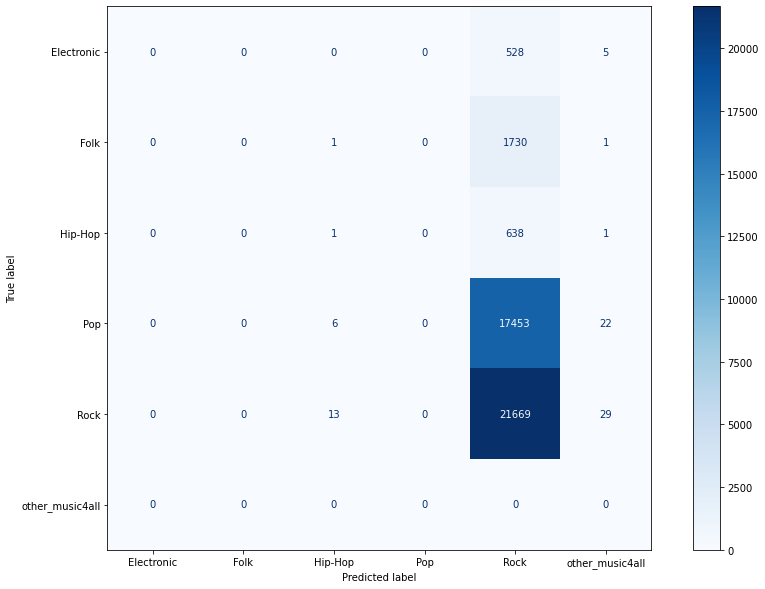

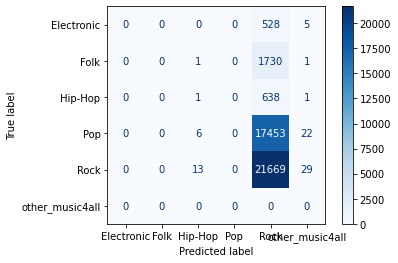

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(15,10))

cm=ConfusionMatrixDisplay.from_predictions(y_true_series, y_pred_series
                                        , cmap=plt.cm.Blues)
#plt.figure(figsize=(10, 10))
#plt.show()

cm.plot(ax=ax, cmap=plt.cm.Blues)

### Load ALBERT from Music4All and predict

In [21]:
!pip3 install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.0 MB/s 


In [22]:
drop_out_rate = 0.3
learning_rate_transfer_learning = 1e-4
learning_rate_fine_tuning = 1e-6
McNemar={}
balanced_accuracies_fine_tune =[]

In [35]:
from transformers import AlbertTokenizer, TFAlbertModel
import numpy as np

split0=splits[0]
split0['X_train'] = prepare_lyrics(split0['X_train'] )
split0['X_test'] = prepare_lyrics(split0['X_test'] )

print(split0['X_train'].shape, split0['X_test'].shape)

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

Xids_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xmask_train = np.zeros((split0['X_train'].shape[0], SEQ_LEN))
Xids_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))
Xmask_test = np.zeros((split0['X_test'].shape[0], SEQ_LEN))

for i, lyric in enumerate(split0['X_train']):
  tokens = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length", add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_train[i,:], Xmask_train[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, lyric in enumerate(split0['X_test']):
  tokens_test = tokenizer.encode_plus(lyric, max_length=SEQ_LEN, truncation =True, padding="max_length"
    , add_special_tokens = True, return_token_type_ids= False, return_attention_mask = True, return_tensors= 'tf')
  Xids_test[i,:], Xmask_test[i,:] = tokens_test['input_ids'], tokens_test['attention_mask']

print("Xids_train.shape, Xids_test.shape: ",Xids_train.shape, Xids_test.shape)

labels_train = np.zeros((split0['y_train'].shape[0], 10))
labels_train[ np.arange(split0['y_train'].shape[0]), split0['y_train'].values] =1
labels_test = np.zeros((split0['y_test'].shape[0], 10))
labels_test[ np.arange(split0['y_test'].shape[0]), split0['y_test'].values] =1

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)
dataset_train = dataset_train.shuffle(42).batch(16)

DS_LEN = len(dataset_train)
SPLIT = 0.9
train = dataset_train.take(round(DS_LEN*SPLIT))
val = dataset_train.skip(round(DS_LEN*SPLIT))
test = dataset_test.batch(16)

(168385,) (42097,)


Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Xids_train.shape, Xids_test.shape:  (168385, 256) (42097, 256)


In [36]:
from transformers import TFAutoModel
from transformers import AlbertTokenizer, TFAlbertModel

SEQ_LEN2=256

print("learning_rate_transfer_learning: ",learning_rate_transfer_learning, "learning_rate_fine_tuning: "
, learning_rate_fine_tuning, "drop_out_rate:", drop_out_rate)
#step1

albert_base = TFAlbertModel.from_pretrained('albert-base-v2')
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN2,), name= 'input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN2,), name='attention_mask')

embeddings = albert_base(input_ids, attention_mask= mask)[0]
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation = 'relu')(X)
X = tf.keras.layers.Dropout(drop_out_rate)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
y= tf.keras.layers.Dense(10, activation = 'softmax' , name= 'outputs')(X)

model1 = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

learning_rate_transfer_learning:  0.0001 learning_rate_fine_tuning:  1e-06 drop_out_rate: 0.3


Downloading:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [37]:
model1.load_weights('/content/drive/MyDrive/music4all/checkpoints/ALBERT_music4all_split0_finetuned2')

We don't use learning rate, it is just declared so that my calculation function do not cause error.

In [40]:
#step4: predict
balanced_acc, McNemar, y_predict=get_balanced_accuracy("ALBERT_from_kaggle" , model1, McNemar, True, drop_out_rate,learning_rate_transfer_learning, learning_rate_fine_tuning )

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning

              precision    recall  f1-score   support

         0.0       0.03      0.13      0.05       533
         1.0       0.09      0.34      0.15      1732
         2.0       0.00      0.02      0.00       640
         3.0       0.33      0.03      0.06     17481
         4.0       0.39      0.06      0.10     21711
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0
         9.0       0.00      0.00      0.00         0

    accuracy                           0.06     42097
   macro avg       0.08      0.06      0.04     42097
weighted avg       0.34      0.06      0.08     42097

0.11599307058419128


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


### Load TFIDF(MNB) from music4all on kaggle dataset

In [25]:
import pickle
filename = DIR+ 'checkpoints/TFIDF_MNB_music4all_split4.sav'
TFIDF_MNB_model = pickle.load(open(filename, 'rb'))

In [26]:
from nltk.corpus import words
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score

split0 = splits[0]
for i, token_list in split0['X_train'].items():
  split0['X_train'][i] =  ' '.join(token_list)

for i, token_list in split0['X_test'].items():
  split0['X_test'][i] =  ' '.join(token_list)

tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words='english', max_df=0.9, min_df=0.01)#max_features=10000
X_train_tfidf = tfidf_vectorizer.fit_transform(split0['X_train']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(split0['X_test']).toarray()

df_X_train_tfidf = pd.DataFrame(X_train_tfidf
                              ,index = split0['X_train'].index
                            , columns=tfidf_vectorizer.get_feature_names())
del(X_train_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
X_resampled, y_resampled = SMOTE().fit_resample(df_X_train_tfidf.to_numpy(), split0['y_train']) 
print(sorted(Counter(y_resampled).items()))

[(0, 86844), (1, 86844), (2, 86844), (3, 86844), (4, 86844)]


In [28]:
predicted_mnb_SMOTE = TFIDF_MNB_model.predict(X_test_tfidf)
print(classification_report(split0['y_test'], predicted_mnb_SMOTE) )
print(balanced_accuracy_score(split0['y_test'], predicted_mnb_SMOTE))

              precision    recall  f1-score   support

           0       0.01      0.06      0.02       533
           1       0.05      0.23      0.09      1732
           2       0.01      0.05      0.01       640
           3       0.37      0.09      0.15     17481
           4       0.50      0.08      0.13     21711
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.09     42097
   macro avg       0.09      0.05      0.04     42097
weighted avg       0.42      0.09      0.13     42097

0.10097342501345993


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning

### Load Glove(SVM-dim200) from music4all on kaggle dataset

In [23]:
def X_train_test_prepare(X_train, X_test):
  first_index =X_train.index[0]
  if type(X_train[first_index]) is not list:
    for idx, lyrics in X_train.items():
      X_train[idx] = lyrics.split(' ')

  first_index =X_test.index[0]
  if type(X_test[first_index]) is not list:
    for idx, lyrics in X_test.items():
      X_test[idx] = lyrics.split(' ')

  return X_train, X_test

In [24]:
import pickle
filename = DIR+ 'checkpoints/Glove_SVM_music4all_split4.sav'
Glove_SVM_model = pickle.load(open(filename, 'rb'))

DIM = 200

In [25]:
from nltk.corpus import words
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score

split0=splits[0]
split0['X_train'], split0['X_test'] = X_train_test_prepare(split0['X_train'], split0['X_test'])
print("=========split: " , 0, "=================")
#1.create model and clf
gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=DIM, min_count=3, sg=1, alpha=0.025, iter=10)

#2.create word embedding and vector representation for each song
gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

#5.Create test embedding and then predict
#Note: this is because test embedding shape changes for each loop
X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
y_test_pred_SMOTE_temp = Glove_SVM_model.predict(X_test_embeddings_temp)
print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

=========split:  0 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  488188
original training_examples_count: 168385
Before merge, vocab:  488188
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  488188
              precision    recall  f1-score   support

           0       0.02      0.04      0.02       533
           1       0.00      0.00      0.00      1732
           2       0.00      0.00      0.00       640
           3       0.47      0.00      0.00     17481
           4       0.58      0.00      0.01     21711
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.00     42097
   macro avg       0.12      0.00      0.00     42097
weighted avg       0.50      0.00      0.01     42097

0.00886723823237748


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning

In [81]:
from nltk.corpus import words
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score

split0=splits[4]
split0['X_train'], split0['X_test'] = X_train_test_prepare(split0['X_train'], split0['X_test'])
print("=========split: " , 4, "=================")
#1.create model and clf
gensim_word2vec_tr_temp = GensimWord2VecVectorizer(size=DIM, min_count=3, sg=1, alpha=0.025, iter=10)

#2.create word embedding and vector representation for each song
gensim_word2vec_tr_temp = gensim_word2vec_tr_temp.fit(split0['X_train'])

#5.Create test embedding and then predict
#Note: this is because test embedding shape changes for each loop
X_test_embeddings_temp = gensim_word2vec_tr_temp.transform(split0['X_test'])
y_test_pred_SMOTE_temp = Glove_SVM_model.predict(X_test_embeddings_temp)
print(classification_report(split0['y_test'], y_test_pred_SMOTE_temp) )
print(balanced_accuracy_score(split0['y_test'], y_test_pred_SMOTE_temp))

=========split:  4 =================
Created glove_wv.
Before build_vocab(X), check if Word2Vec(sentences=X) builds a vocab :  487373
original training_examples_count: 168386
Before merge, vocab:  487373
Updated build_vocab by Glove.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


intersect completed.
After merge, vocab:  487373
              precision    recall  f1-score   support

           0       0.06      0.03      0.04       533
           1       0.11      0.00      0.00      1732
           2       0.00      0.00      0.00       639
           3       0.47      0.02      0.04     17481
           4       1.00      0.00      0.00     21711
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.01     42096
   macro avg       0.18      0.01      0.01     42096
weighted avg       0.72      0.01      0.02     42096

0.011426489782730372


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning

In [90]:
code2genre[5] = 'other_music4all1'
code2genre[6] = 'other_music4all2'
code2genre[7] = 'other_music4all3'
code2genre[8] = 'other_music4all4'
code2genre

{0: 'Electronic',
 1: 'Folk',
 2: 'Hip-Hop',
 3: 'Pop',
 4: 'Rock',
 5: 'other_music4all1',
 6: 'other_music4all2',
 7: 'other_music4all3',
 8: 'other_music4all4'}

In [97]:
len(split0['X_test'])

42096

In [96]:
TEST_SIZE

42097

In [98]:
y_pred_list = [0] * len(split0['X_test'])
for i, pred in enumerate(y_test_pred_SMOTE_temp):
  y_pred_list[i] = code2genre[pred]

y_true_list = []
for i, y_true in enumerate(split0['y_test']):
  y_true_list.append( code2genre[y_true] )

y_pred_series = pd.Series(data = y_pred_list)
y_true_series = pd.Series(data = y_true_list)

In [99]:
y_pred_series

0        other_music4all1
1        other_music4all1
2        other_music4all1
3        other_music4all1
4        other_music4all1
               ...       
42091    other_music4all1
42092    other_music4all1
42093                 Pop
42094    other_music4all1
42095    other_music4all1
Length: 42096, dtype: object

In [92]:
y_true_series

0        Hip-Hop
1        Hip-Hop
2        Hip-Hop
3            Pop
4           Rock
          ...   
42091       Rock
42092        Pop
42093    Hip-Hop
42094       Rock
42095        Pop
Length: 42096, dtype: object

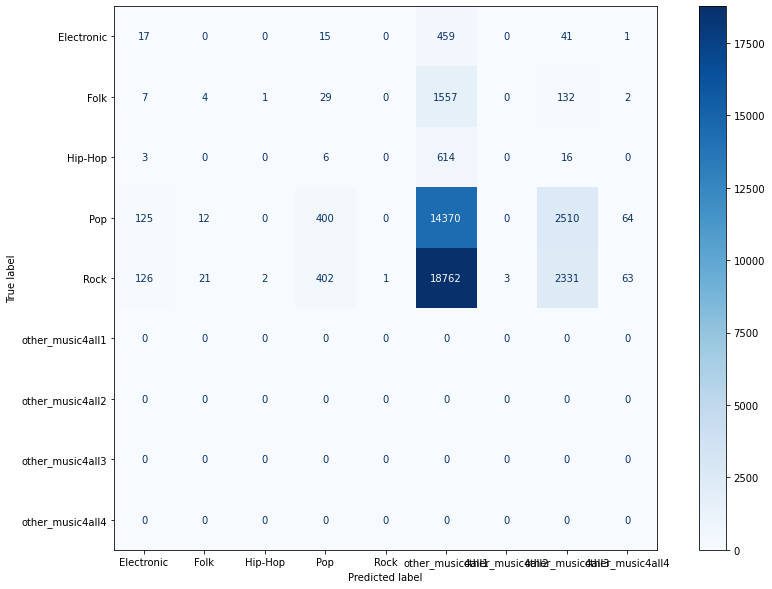

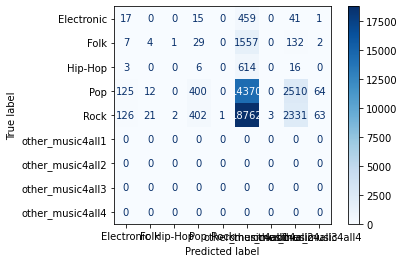

In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(15,10))

cm=ConfusionMatrixDisplay.from_predictions(y_true_series, y_pred_series
                                        , cmap=plt.cm.Blues)
#plt.figure(figsize=(10, 10))
#plt.show()

cm.plot(ax=ax, cmap=plt.cm.Blues)

In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(df_X_train_tfidf.to_numpy(), split0['y_train']) 
print(sorted(Counter(y_resampled).items()))

[(0, 86844), (1, 86844), (2, 86844), (3, 86844), (4, 86844)]


In [ ]:
predicted_mnb_SMOTE = TFIDF_MNB_model.predict(X_test_tfidf)
print(classification_report(split0['y_test'], predicted_mnb_SMOTE) )
print(balanced_accuracy_score(split0['y_test'], predicted_mnb_SMOTE))